<a href="https://colab.research.google.com/github/bacdao/LAML/blob/main/Figure2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Differentially methylated probes calling

###Note: It is recommended to perform DMP calling on a local Linux environment rather than using Google Colab, as installing the ChAMP tool can be challenging within Colab.

##Install ChAMP tool

In [ ]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# BiocManager::install("ChAMP")

library(ChAMP)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Installing package(s) 'BiocVersion', 'ChAMP'

also installing the dependencies ‘formatR’, ‘rjson’, ‘deldir’, ‘RcppEigen’, ‘abind’, ‘bitops’, ‘R.oo’, ‘R.methodsS3’, ‘lambda.r’, ‘futile.options’, ‘interactiveDisplayBase’, ‘filelock’, ‘restfulr’, ‘AnnotationFilter’, ‘ProtGenerics’, ‘dichromat’, ‘VariantAnnotation’, ‘Rhtslib’, ‘png’, ‘jpeg’, ‘interp’, ‘plogr’, ‘TxDb.Hsapiens.UCSC.hg19.knownGene’, ‘affyio’, ‘MatrixGenerics’, ‘S4Arrays’, ‘RCurl’, ‘GenomeInfoDbData’, ‘multtest’, ‘scrime’, ‘sparseMatrixStats’, ‘R.utils’, ‘rhdf5’, ‘rhdf5filters’, ‘Rhdf5lib’, ‘futile.logger’, ‘snow’, ‘BH’, ‘AnnotationHub’, ‘BiocFileCache’, ‘gtools’, ‘permute’, ‘BSgenome’,

In [ ]:
install.packages(c("ggrepel", "readxl", "ggpubr", "viridis", "dplyr", "gghalves", "VennDiagram"))

In [ ]:
library(ggplot2)
library(data.table)
library(ggrepel)
library(readxl)
library(ggpubr)
library(viridis)
library(dplyr)
library(gghalves)
library(VennDiagram)

##Loading data

##Labeling the 173 samples into 2 group 'FLT3 Mutant' and 'FLT3 wildtype'

In [6]:
designTSV <- fread("https://raw.githubusercontent.com/bacdao/LAML/main/data/design.tsv", sep="\t", header=T)
head(designTSV)

Title,Group
<chr>,<chr>
TCGA-AB-2803-03,FLT3 Wild_type
TCGA-AB-2805-03,FLT3 Wild_type
TCGA-AB-2806-03,FLT3 Wild_type
TCGA-AB-2807-03,FLT3 Wild_type
TCGA-AB-2808-03,FLT3 Wild_type
TCGA-AB-2810-03,FLT3 Wild_type


#DEGs file from cbioportal

In [8]:
deg <- fread("https://raw.githubusercontent.com/bacdao/LAML/main/data/deg.tsv", sep = "\t", header = T)
head(deg)

Gene,Cytoband,(A) FLT3 mutation,(B) FLT3 non mutation,(A) FLT3 mutation,(B) FLT3 non mutation,Log Ratio,p-Value,q-Value,Higher expression in
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SDC1,2p24.1,0.59,1.49,0.40,1.05,-0.90,8.72e-14,1.70e-09,(B) FLT3 non mutation
LGALS3BP,17q25,6.21,4.08,1.38,2.07,2.14,1.43e-12,1.39e-08,(A) FLT3 mutation
AMPD1,1p13.2,0.21,0.75,0.26,0.69,-0.54,4.33e-12,2.81e-08,(B) FLT3 non mutation
ADAM6,14q32.33,3.97,5.50,1.09,1.64,-1.53,6.67e-11,2.28e-07,(B) FLT3 non mutation
HID1,17q25.1,0.32,0.81,0.27,0.65,-0.48,7.97e-11,2.28e-07,(B) FLT3 non mutation
SCNN1B,16p12.2-p12.1,0.08,0.28,0.09,0.28,-0.20,8.83e-11,2.28e-07,(B) FLT3 non mutation


##Keeping useful information

In [12]:
deg_filter <- data.frame(deg$Gene,deg$`Log Ratio`,deg$`q-Value`)
colnames(deg_filter) <- c("gene","Log2FC","qvalue")

##After completing the DMP calling analysis, you can expect to have results similar to the following:

In [7]:
DMP <- fread("https://raw.githubusercontent.com/bacdao/LAML/main/data/DMP.tsv", header = T)
head(DMP)

logFC,AveExpr,t,P.Value,adj.P.Val,B,C_AVG,T_AVG,deltaBeta,CHR,⋯,feature,cgi,feat.cgi,UCSC_CpG_Islands_Name,DHS,Enhancer,Phantom,Probe_SNPs,Probe_SNPs_10,probeID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>
-0.2327954,0.6146601,-8.125071,8.419218e-14,2.017955e-08,20.01816,0.6792507,0.4464554,-0.2327954,6,⋯,5'UTR,opensea,5'UTR-opensea,,NA,TRUE,,rs35278640,,cg12232118
-0.2372033,0.8340115,-8.091791,1.026281e-13,2.017955e-08,19.82215,0.8998251,0.6626218,-0.2372033,19,⋯,Body,island,Body-island,chr19:13135317-13136169,NA,NA,,,,cg26767614
-0.2238275,0.7618051,-7.973394,2.070067e-13,2.713554e-08,19.12774,0.8239075,0.6000800,-0.2238275,X,⋯,Body,shelf,Body-shelf,chrX:152612775-152613464,NA,NA,,,,cg15317375
-0.2351467,0.6787110,-7.882125,3.544572e-13,3.484810e-08,18.59565,0.7439540,0.5088074,-0.2351467,2,⋯,IGR,opensea,IGR-opensea,,TRUE,TRUE,,,,cg04849850
-0.2608458,0.7607761,-7.749485,7.707205e-13,6.061809e-08,17.82753,0.8331494,0.5723037,-0.2608458,3,⋯,5'UTR,opensea,5'UTR-opensea,,NA,NA,,,,cg13458803
-0.1868203,0.8135271,-7.672868,1.203854e-12,7.788728e-08,17.38669,0.8653616,0.6785413,-0.1868203,6,⋯,1stExon,opensea,1stExon-opensea,,NA,TRUE,,rs35278640,,cg27583815


In [ ]:
myGSEA_DMR <- read.table("~/Downloads/article/laml/data/GSEA_DMR.tsv", header = T, fill = TRUE, sep ="\t")


# Merge DMP and DEG with adjusted p_value <0.05 based on gene names

In [14]:
DMP.deg <- merge(DMP,subset(deg_filter, deg_filter$qvalue<0.05), by.x="gene", by.y="gene")
dim(DMP.deg)

[1] 1450   26

##Sorting 'CHR' (chromosome) column

In [15]:
chrOrder <-c((1:22),"X","Y","M")
DMP.deg$CHR <- factor(DMP.deg$CHR, chrOrder, ordered=TRUE)

#1.FIGURE_2.A

## Bar plot for distribution of 1450 probes by chromosome according to gene region location

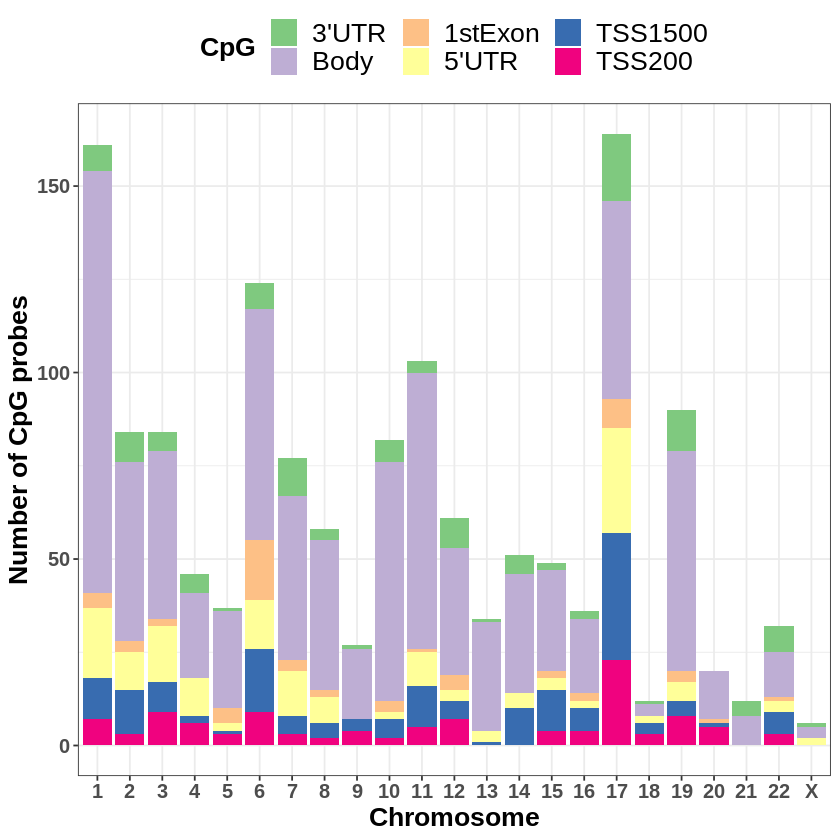

In [19]:
ggplot(DMP.deg, aes(x=CHR, fill=factor(feature, levels=c("3'UTR","Body","1stExon","5'UTR","TSS1500","TSS200")))) +
  geom_bar(position="stack") +scale_fill_brewer(palette="Accent") +
    labs(x="Chromosome", y="Number of CpG probes", fill="CpG") +
      theme_bw() +
        theme(axis.text = element_text(size = 12, face = "bold"),
  axis.title = element_text(size = 16,face = "bold"),legend.title=element_text(size=16, face="bold"),
  legend.position = "top",
  legend.text=element_text(size=16))

#1.FIGURE_2.B

##Bar plot for distribution of 1450 probes by chromosome according to CpG sites

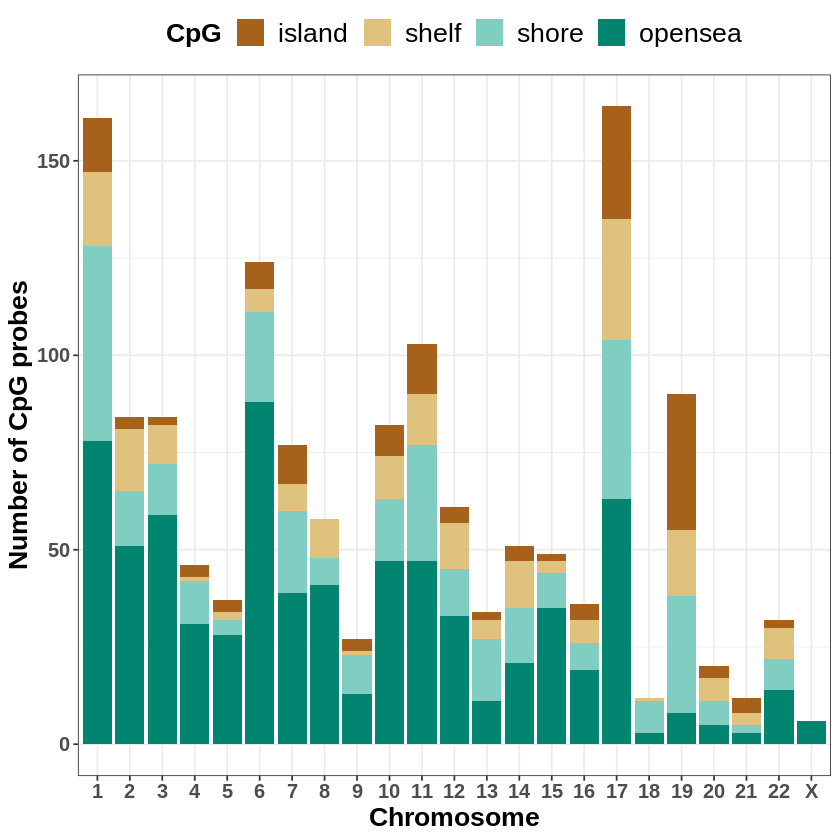

In [20]:
ggplot(DMP.deg, aes(x=CHR, fill=factor(cgi, levels=c("island","shelf","shore","opensea")))) +
  geom_bar(position="stack") +
  scale_fill_brewer(palette="BrBG") +
  labs(x="Chromosome", y="Number of CpG probes", fill="CpG") +
  theme_bw() +
  theme(axis.text = element_text(size = 12, face = "bold"),
    axis.title = element_text(size = 16,face = "bold"),legend.title = element_text(size=16, face="bold"), legend.position = 'top',
    legend.text = element_text(size=16))

#1.FIGURE_2.C

## Plot for distribution of DMR gene set enrichment analysis

###Continue to perform DMR calling

In [ ]:
###DMRs calling
df <- as.matrix(df)
myDMR_Bum <- champ.DMR(beta=df,pheno=designTSV$Sample_Group,method="Bumphunter")
DMR_Bum <- as.data.frame(myDMR_Bum$BumphunterDMR)

myGSEA <- champ.GSEA(beta=df,DMP=myDMP[[1]], DMR=myDMR_Bum, arraytype="450K",adjPval=0.05, method="fisher")
myGSEA_DMR <- myGSEA$DMR

###You can expect to have results similar to the following

In [26]:
myGSEA_DMR <- fread("https://raw.githubusercontent.com/bacdao/LAML/main/data/GSEA_DMR.tsv", header = T)
myGSEA_DMR$rlogpvalue <- -log10(myGSEA_DMR$adjPval)
myGSEA_DMR

Gene_List,nList,nRep,fRep,nOVLAP,OR,P.value,adjPval,Genes,rlogpvalue
<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
MIKKELSEN_IPS_WITH_HCP_H3K27ME3,102,102,1.0000000,7,31.288284,9.939111e-09,8.309097e-05,HOXB3 GFI1 HOXB2 HOXB5 HOXA11 PRRT1 HOXA2,4.080446
HOX_GENES,65,61,0.9384615,5,36.520124,5.990351e-07,2.503967e-03,HOXB5 HOXA2 HOXA11 HOXB3 HOXB2,2.601371
VALK_AML_WITH_FLT3_ITD,40,39,0.9750000,4,45.809769,3.491639e-06,9.730035e-03,HOXB5 LGALS3BP HOXB2 HOXB3,2.011886
TTCYNRGAA_V$STAT5B_01,335,311,0.9283582,7,9.684517,1.829260e-05,3.823154e-02,HOXA11 TRIM15 TRIM46 CMTM2 HOXA2 KRTCAP2 PIK3R1,1.417578


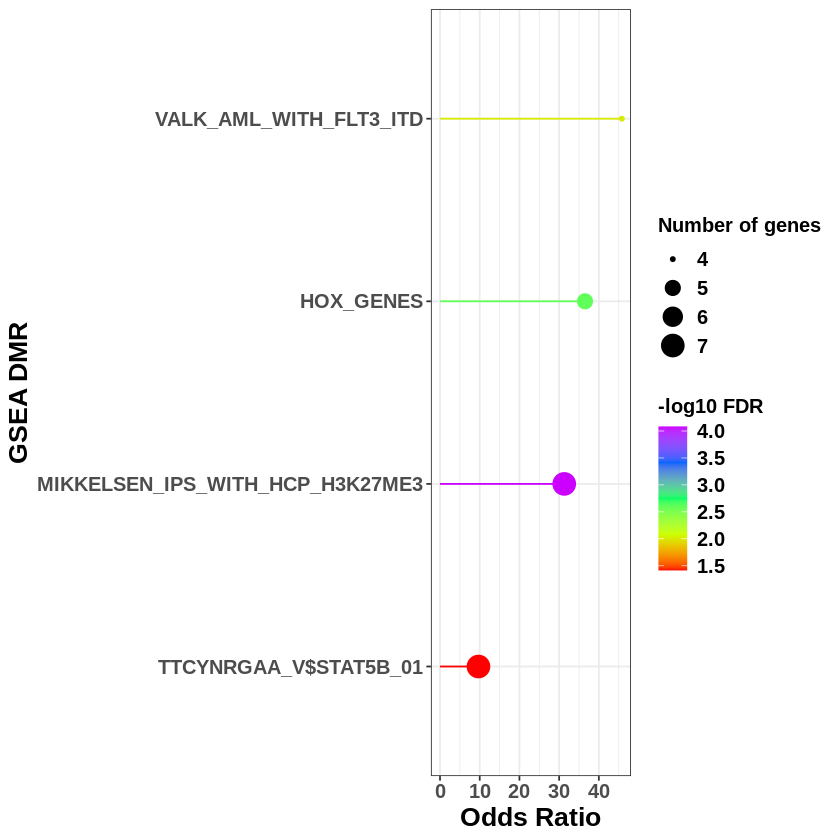

In [27]:
ggplot(myGSEA_DMR, aes(x=OR, xend=0, y=reorder(Gene_List, OR), yend=Gene_List, color = rlogpvalue)) + scale_color_gradientn(colours = rainbow(5)) +
 geom_segment(stat="identity",position="identity") +
 geom_point(aes(size=nOVLAP)) + theme_bw() +
  theme(text = element_text(size = 12, face="bold"), axis.text = element_text(size = 12, face = "bold"), axis.title=element_text(size = 16,face = "bold"), legend.title=element_text(size=12, face="bold"), legend.text=element_text(size=12, face = "bold")) + labs(x="Odds Ratio", y="GSEA DMR", colour="-log10 FDR", size="Number of genes")

#1.FIGURE_2.D

## Venn diagram to visualize the overlapping genes containing Differentially Methylated Probes (DMPs) and Differentially Expressed Genes (DEGs)

In [28]:
DMP.deg.sig <- subset(DMP.deg, abs(DMP.deg$Log2FC)>=0.5)
dim(DMP.deg.sig)

[1] 550  26

In [31]:
#Build function for Venn diagram in R
display_venn <- function(x, ...){
  library(VennDiagram)
  grid.newpage()
  venn_object <- venn.diagram(x, filename = NULL, ...)
  grid.draw(venn_object)
}

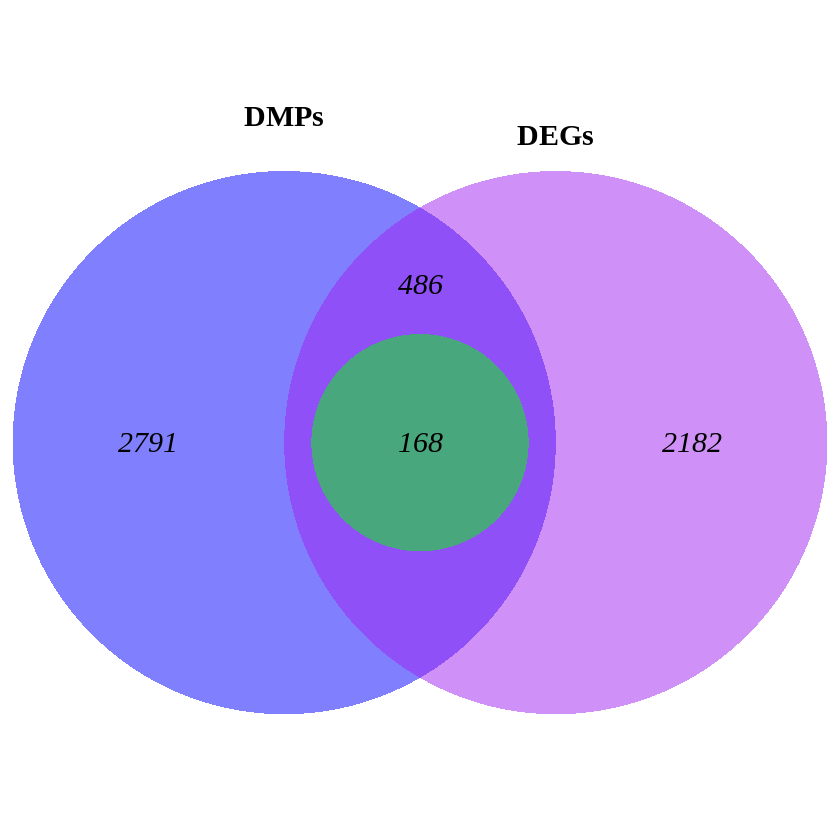

In [35]:
venn2 <- list(DEGs = subset(deg_filter,deg_filter$qvalue <0.05)$gene, DMP.deg.sig$gene, DMPs= as.data.frame(table(DMP$gene))$Var1)

display_venn(
  venn2,
  lwd=1, lty ="blank",
  fill = c("purple", "green", "blue"), cex= 1.5, fontface= "italic", dist=c(0.05,0.05,0.05), cat.cex =1.5, cat.fontface="bold", cat.pos=c(0,0,0), cat.dist=c(0.05, 0.05, 0.05))

#1.FIGURE_2.E

## Bar plot for distribution of DMPs located in above 168 DEGs

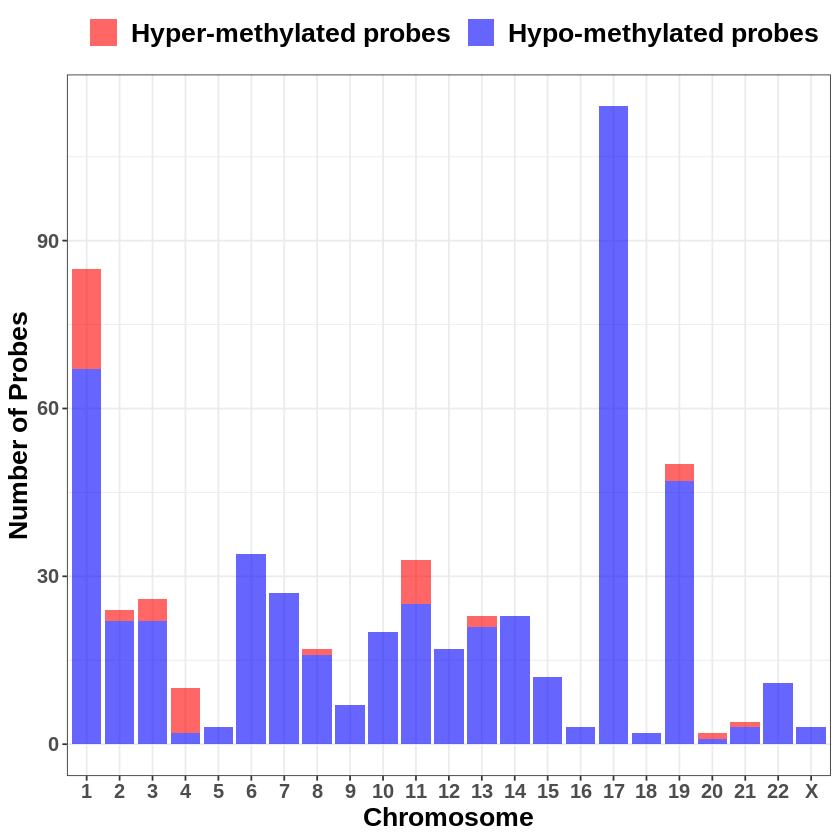

In [36]:
DMP.deg.sig$Meth_stat <- ifelse(DMP.deg.sig$deltaBeta>=0,"Hyper-methylated probes","Hypo-methylated probes")

ggplot(DMP.deg.sig, aes(x=CHR, fill=Meth_stat)) + geom_bar(position="stack", alpha = 0.6) + labs(x="Chromosome", y="Number of Probes", fill="") + theme_bw() +
  theme(axis.text = element_text(size = 12, face = "bold"),
    axis.title = element_text(size = 16,face = "bold"),legend.title=element_text(size=16, face="bold"), legend.text=element_text(size=16, face = "bold"),legend.position="top") + scale_fill_manual(values=c("red","blue"))

In [37]:
table(DMP.deg.sig$Meth_stat)


Hyper-methylated probes  Hypo-methylated probes 
                     48                     502 

#1.FIGURE_2.F

## Bar plot for distribution of 168 DEGs

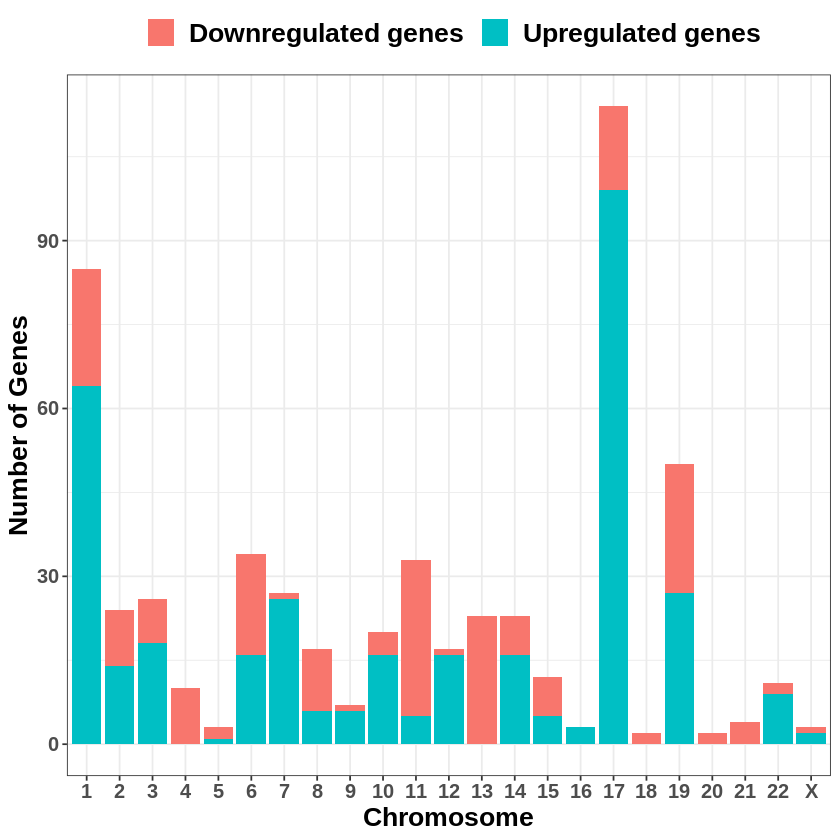

In [38]:
DMP.deg.sig$Exp_stat <- ifelse(DMP.deg.sig$Log2FC>=0,"Upregulated genes","Downregulated genes")

ggplot(DMP.deg.sig, aes(x=CHR, fill=Exp_stat)) + geom_bar(position="stack") + labs(x="Chromosome", y="Number of Genes", fill="") + theme_bw() +
theme(axis.text = element_text(size = 12, face = "bold"), axis.title=element_text(size = 16,face = "bold"), legend.title=element_text(size=16, face="bold"), legend.text=element_text(size=16, face = "bold"), legend.position="top")


In [39]:
table(DMP.deg.sig$Exp_stat)


Downregulated genes   Upregulated genes 
                201                 349 